In [1]:
!pip install pillow

In [2]:
!pip install opencv-python

In [24]:
# Basic Imports
import numpy as np
import pandas as pd

# Project Imports
import os
import cv2
from PIL import Image

# Tensorflow
import tensorflow as tf
import tensorflow_io as tfio

In [4]:
# Path & Variables
CUR_DIR = os.getcwd()
DATA_DIR = os.path.join(CUR_DIR, 'data')

RAW_DATA = os.path.join(DATA_DIR, 'raw_data')
DATA_CLEAN = os.path.join(DATA_DIR, 'data_clean')

DIM = (128, 128)

In [5]:
# Check & create target dir
if not os.path.exists(DATA_CLEAN):
    os.makedirs(DATA_CLEAN)

In [6]:
# Convert & Process image into npy

for file in os.listdir(RAW_DATA):
    if file.endswith(".jpg"):
        img = cv2.imread(os.path.join(RAW_DATA, file))
        resize_img = cv2.resize(img, DIM)
        # img_array = np.array(img)
        file_name = os.path.splitext(file)[0]
        np.save(os.path.join(DATA_CLEAN, file_name), resize_img)

In [7]:
# Adding the target
metadata = pd.read_excel(os.path.join(DATA_DIR, 'metadata.xlsx'))
img = np.load(os.path.join(DATA_CLEAN, os.listdir(DATA_CLEAN)[0]))

metadata_sample = metadata[['cancer', 'image_id']]
metadata_sample.head(2)

,cancer,image_id
0,0,462822612
1,0,1459541791


In [39]:
# Create CSV for the sample (array & Id)
image_id_array = []
image_id_jepg = []
image_array_path = []
image_jpeg_path = []

for img in os.listdir(DATA_CLEAN):
    image_id_array.append(np.int64(int(os.path.splitext(img)[0])))
    image_array_path.append(os.path.join(DATA_CLEAN, img))

for img in os.listdir(RAW_DATA):
    if img.endswith('.jpg'):
        image_id_jepg.append(np.int64(int(os.path.splitext(img)[0])))
        image_jpeg_path.append(os.path.join(RAW_DATA, img))


In [42]:

image_array_csv = pd.DataFrame(dict(
    image_id=image_id_array,
    image_array_path=image_array_path
))


In [41]:

image_jpeg_csv = pd.DataFrame(dict(
    image_id=image_id_jepg,
    image_jpeg_path=image_jpeg_path
))


In [43]:

display(image_array_csv.head(2), image_jpeg_csv.head(2))


,image_id,image_array_path
0,257647980,/Users/jynxzz_air/code/lewagon-projects/projec...
1,879478870,/Users/jynxzz_air/code/lewagon-projects/projec...


,image_id,image_jpeg_path
0,886468142,/Users/jynxzz_air/code/lewagon-projects/projec...
1,1415408900,/Users/jynxzz_air/code/lewagon-projects/projec...


In [45]:
final_csv = image_array_csv.merge(metadata_sample, on= 'image_id', how='left')
final_csv = image_jpeg_csv.merge(final_csv, on= 'image_id', how='left')
final_csv.shape

(1667, 4)

In [46]:
final_csv.head()

,image_id,image_jpeg_path,image_array_path,cancer
0,886468142,/Users/jynxzz_air/code/lewagon-projects/projec...,/Users/jynxzz_air/code/lewagon-projects/projec...,0
1,1415408900,/Users/jynxzz_air/code/lewagon-projects/projec...,/Users/jynxzz_air/code/lewagon-projects/projec...,0
2,307719234,/Users/jynxzz_air/code/lewagon-projects/projec...,/Users/jynxzz_air/code/lewagon-projects/projec...,0
3,340925683,/Users/jynxzz_air/code/lewagon-projects/projec...,/Users/jynxzz_air/code/lewagon-projects/projec...,0
4,1079750245,/Users/jynxzz_air/code/lewagon-projects/projec...,/Users/jynxzz_air/code/lewagon-projects/projec...,0


In [47]:
final_csv.to_csv(os.path.join(DATA_DIR, 'final.csv'))

In [79]:
# Get Labels & Images

variables = pd.read_csv(os.path.join(DATA_DIR, 'final.csv'), index_col= None, header=[0])

labels = []
images_ids = []
actual_images = []
resize_images = []

for idx, image_id, image_jpeg_path, image_array_path, label in variables.values:
    # Get labels
    labels.append(label)

    # Get images
    img = tf.io.read_file(image_jpeg_path)
    img = tf.io.decode_jpeg(img)

    actual_images.append(img)

    # Resize images
    img = tf.image.resize(img, [128, 128], method='nearest')
    resize_images.append(img)


In [101]:
tf.cast(labels, dtype= tf.int32).shape, len(labels), tf.constant(tf.cast(labels, dtype= tf.int32), shape= (1667, 1)).shape

(TensorShape([1667]), 1667, TensorShape([1667, 1]))

In [80]:
# Labels to Tensor
labels_tensor = tf.cast(labels, dtype= tf.int32)
labels_tensor = tf.constant(labels_tensor, shape=(1667, 1, 1))

# Images to Tensor
image_tensor = tf.cast(resize_images, dtype= tf.float32) / 255
image_tensor = tf.constant(image_tensor, shape=(1667, 1, 128, 128, 1))

In [81]:
# Create Dataset
dataset = tf.data.Dataset.from_tensor_slices((image_tensor, labels_tensor))
dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(1, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(1, 1), dtype=tf.int32, name=None))>

In [82]:
# Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

def initialize_model():

    model = Sequential()
    model.add(Conv2D(16, (4, 4), input_shape = (128, 128, 1), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units = 10, activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid'))


    return model

model = initialize_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 125, 125, 16)      272       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 14, 14, 64)       

In [83]:

#####
# Callback
#####
class custom_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if( logs['accuracy'] >= 0.97 ):
            self.model.stop_training = True

custom_callback = custom_callback()

#####
# Optimizer
#####
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.000001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,
    name='Adam'
)

#####
# Loss Fn
#####
lossfn = tf.keras.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    name='binary_crossentropy'
)

#####
# Model Summary
#####
model.compile(optimizer=optimizer, loss=lossfn, metrics=['accuracy'] )


In [84]:
history = model.fit(
    dataset,
    batch_size= 32,
    epochs= 5,
    callbacks=[custom_callback]
)

Epoch 1/5
1667/1667 [==============================] - 19s 11ms/step - loss: 0.6445 - accuracy: 0.8224
Epoch 2/5
1667/1667 [==============================] - 20s 12ms/step - loss: 0.4645 - accuracy: 0.9778


In [102]:
import matplotlib.pyplot as plt

list_Image = tf.constant( image_tensor, shape=( 1667, 128, 128, 1) ).numpy()
type(list_Image)

numpy.ndarray

1/1 [==============================] - 0s 14ms/step


ValueError: num must be an integer with 1 <= num <= 36, not 37

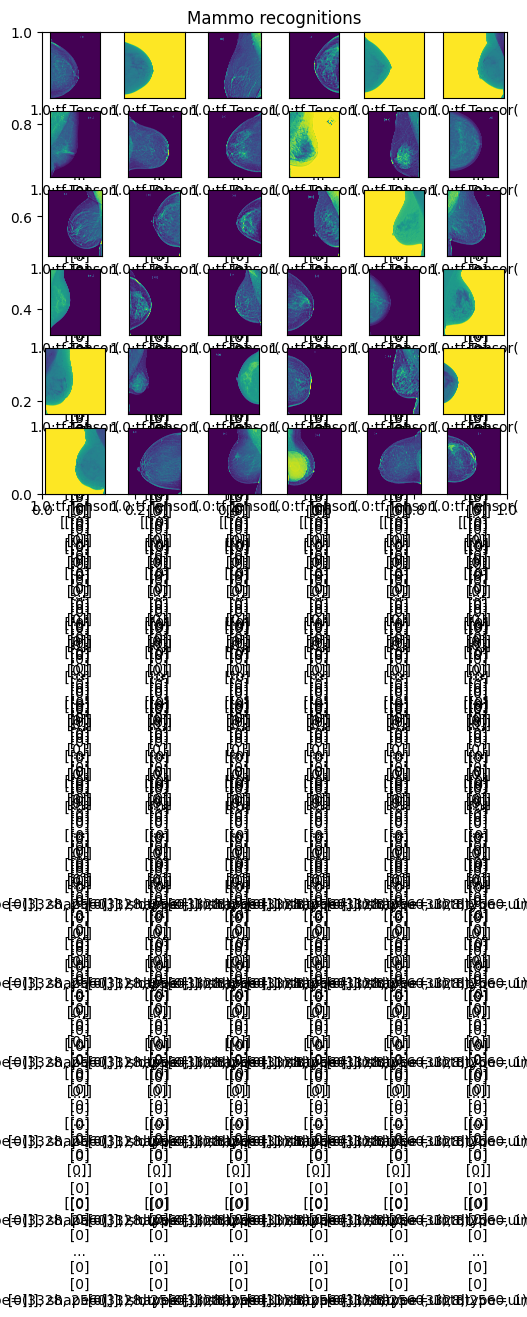

In [103]:

plt.figure(figsize=(6,6))
plt.title("Mammo recognitions")

for i in range(len(list_Image)):
    img = tf.keras.preprocessing.image.array_to_img(
        list_Image[i],
        data_format=None,
        scale=True
    )

    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(actual_images[i])
    plt.xlabel(str(round(score[tf.math.argmax(score).numpy()].numpy(), 2)) + ":" +  str(actual_images[tf.math.argmax(score)]))

plt.show()